## Cluster sizes Usher
The goal of this notebook is to compare the cluster sizes resulting from stop mutations in ORF8 vs. syn & missense mutations.
1. I'll compare raw size of clusters & time of circulation for stop vs. missense vs. synonymous.
2. I'll run a permutation test to compare see if observed cluster sizes & times of circulation are larger than would be expected for samples from that same backbone.


### Set up & loading

In [1]:
import os
import pandas as pd
from Bio import Phylo
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import json

In [2]:
%load_ext line_profiler

In [3]:
os.chdir('/Users/cwagner2/Work/projects/covid/long-deletions/')

In [4]:
## Matplot lib settings
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize']= 14
mpl.rcParams['legend.fontsize']=12
mpl.rcParams['legend.title_fontsize']=14

In [6]:
muts = pd.read_csv('usher/trimmed/usher_translations.tsv',sep='\t')

In [5]:
tree = Phylo.read('usher/trimmed/trimmed_2023-05-01.all.nwk','newick')

In [8]:
stats = pd.read_csv('usher/trimmed/usher_nodes.tsv',sep='\t')

### Raw comparison of missense vs nonsense vs synonymous clades

In [6]:
def load_dates(path):
    df = pd.read_csv(path,sep='\t',usecols=['strain','date'],compression='gzip')
    df = df[~df.date.isna()]
    df = df[~df.date.str.contains('?',regex=False)]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('strain',inplace=True)
    return df

def find_nodes(muts, gene):
    '''
    Finds nodes containing only a single mutation in a gene
    '''
    aa = muts['aa_mutations']
    idxs = [i for i,j in enumerate(aa) if ';' not in j]
    gene_idxs = [idx for idx in idxs if aa[idx].split(':')[0] == gene]
    gene_aa = [aa[idx].split(':')[1] for idx in gene_idxs]
    ogs = [g_aa[0] for g_aa in gene_aa]
    news = [g_aa[-1] for g_aa in gene_aa]
    mut_type = []
    for og, new in zip(ogs, news):
        if og == new:
            mut_type.append('synonymous')
        elif new == '*':
            mut_type.append('nonsense')
        elif og != '*':
            mut_type.append('missense')
        else:
            mut_type.append('undoStop')
    nodes = pd.DataFrame({'node_id': muts['node_id'][gene_idxs], 'aa_mutations':muts['aa_mutations'][gene_idxs], 'nt_mutations':muts['nt_mutations'][gene_idxs], 'codon_change':muts['codon_changes'][gene_idxs],'mut_type':mut_type}).reset_index(drop=True)
    return nodes

def tabulate_names(tree):
    names = {}
    for idx, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(idx)
        names[clade.name] = clade
    return names

def get_leaves(node, named):
    #obj = named[node]
    #leaves = obj.get_terminals()
    leaves = named[node].get_terminals()
    names = [leaf.name for leaf in leaves]
    return names

def get_time(node,named,date_df):
    leaves = get_leaves(node,named)
    dates = date_df.loc[leaves]['date']
    time = max(dates) - min(dates)
    return time.days

def get_times(df,named,date_df):
    time_vect = np.vectorize(get_time,excluded=[1,2])
    df['days_circulated'] = time_vect(df['node_id'],named,date_df)
    return df

In [7]:
# Map node ids to tree ojbect
named = tabulate_names(tree)

In [9]:
# Generate df of ORF8 nodes
nodes = find_nodes(muts,'ORF8')

In [10]:
# Add in node size
merged = nodes.merge(stats,how='left', left_on = 'node_id', right_on = 'node')

In [11]:
merged.head()

,node_id,aa_mutations,nt_mutations,codon_change,mut_type,node,leaf_count,mut_count,mut_density,rev_from_lineage
0,England/SHEF-BFFC7/2020|2020-03-25,ORF8:W45L,G28027T,TGG>TTG,missense,England/SHEF-BFFC7/2020|2020-03-25,1,1,1.0,0
1,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,ORF8:F6F,C27911T,TTC>TTT,synonymous,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,1,1,1.0,0
2,GRC/213_34051/2020|MT459881.1|2020-03-14,ORF8:E106G,A28210G,GAA>GGA,missense,GRC/213_34051/2020|MT459881.1|2020-03-14,1,1,1.0,0
3,USA/CA-CZB-1020/2020|MT438738.1|2020-04-22,ORF8:W45C,G28028T,TGG>TGT,missense,USA/CA-CZB-1020/2020|MT438738.1|2020-04-22,1,1,1.0,0
4,node_73,ORF8:E110*,G28221T,GAG>TAG,nonsense,node_73,2,2,1.0,0


In [8]:
dates_df = load_dates('usher/public-2023-05-01.metadata.tsv.gz')

In [14]:
# Add in circulation time
complete = get_times(merged,named,dates_df)

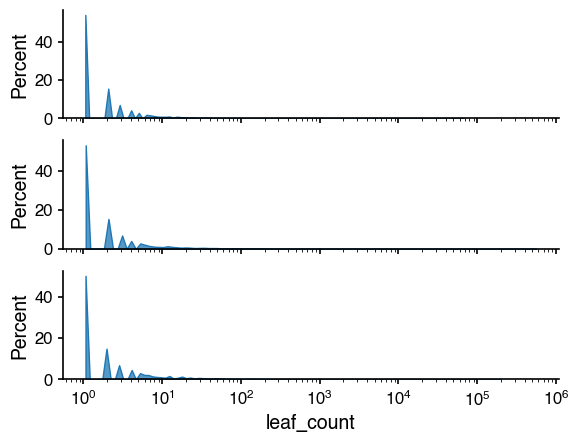

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=1,sharex=True)
for plot,mut in zip([0,1,2],['synonymous','missense','nonsense']):
    sns.histplot(data=complete[complete.mut_type==mut],x='leaf_count',log_scale=True,ax=ax[plot],element='poly',stat='percent',bins=100)
    #ax[plot].

In [19]:
def plot_distributions(df,var,log_scale,axis):
    fig, ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(4,6))
    for plot,mut,color in zip([0,1,2],['synonymous','missense','nonsense'],['c','m','y']):
        data = df[df.mut_type==mut]
        per75 = np.nanpercentile(data[var],75)
        sns.histplot(data=data,x=var,ax=ax[plot],stat='percent',bins=100,zorder=1,log_scale=log_scale,color=color)
        ax[plot].axvline(x=per75,linestyle='dashed',color='black',lw=1,zorder=2,label='75th percentile: ' + str(per75))
        print(per75)
        ax[plot].set_title(mut)
        ax[plot].legend()
        ax[plot].set_xlabel(axis)
    return fig

15.0
17.0
22.0


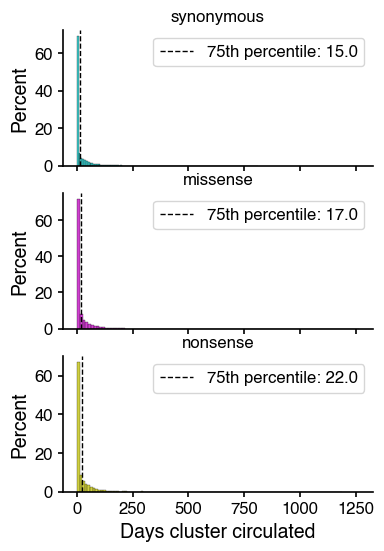

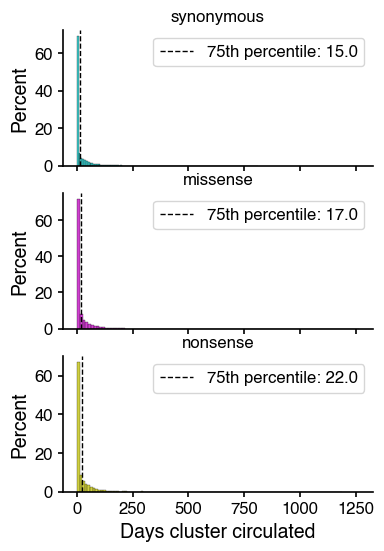

In [20]:
plot_distributions(complete,'days_circulated',False,'Days cluster circulated')

3.0
3.0
4.0


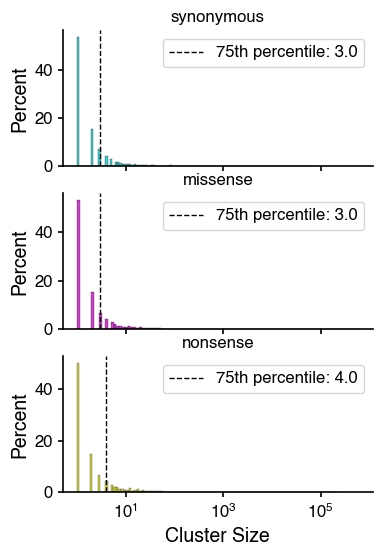

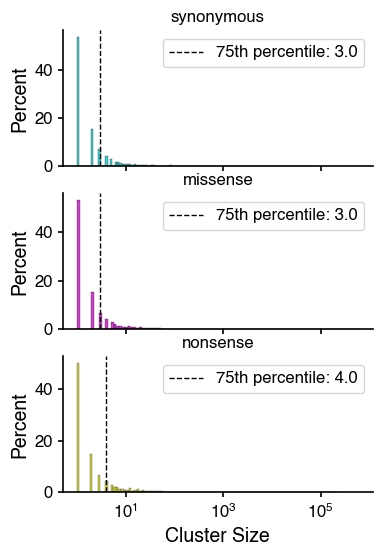

In [21]:
plot_distributions(complete,'leaf_count',True, 'Cluster Size')

In [22]:
def plot_distributions_noS(df,var,log_scale,axis):
    fig, ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(4,6))
    for plot,mut,color in zip([0,1,2],['synonymous','missense','nonsense'],['c','m','y']):
        data = df[(df.mut_type==mut) & (df.leaf_count>1)]
        per75 = np.nanpercentile(data[var],50)
        sns.histplot(data=data,x=var,ax=ax[plot],stat='percent',bins=100,zorder=1,log_scale=log_scale,color=color)
        ax[plot].axvline(x=per75,linestyle='dashed',color='black',lw=1,zorder=2,label='50th percentile: ' + str(per75))
        print(per75)
        ax[plot].set_title(mut)
        ax[plot].legend()
        ax[plot].set_xlabel(axis)
    return fig

4.0
4.0
4.0


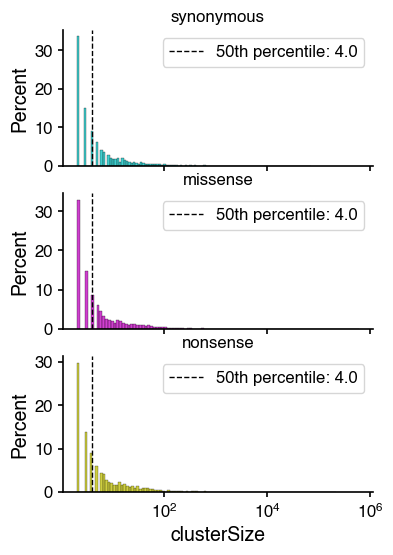

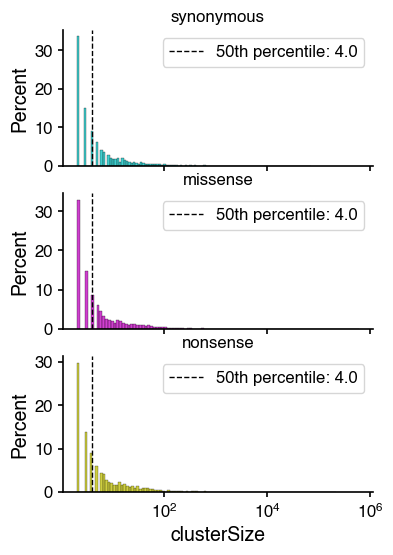

In [23]:
plot_distributions_noS(complete,'leaf_count',True,'clusterSize')

18.0
20.0
22.0


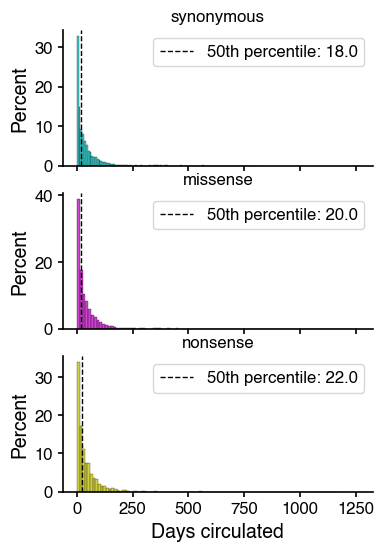

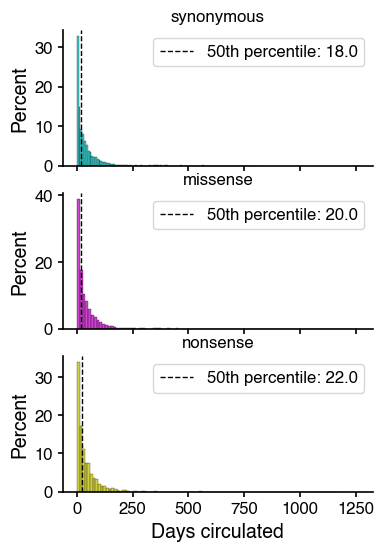

In [24]:
plot_distributions_noS(complete,'days_circulated',False,'Days circulated')

In [5]:
working_df = pd.read_csv('usher/trimmed/orf8clades.tsv',sep='\t')

In [6]:
working_df.head()

,node_id,aa_mutations,nt_mutations,codon_change,mut_type,node,leaf_count,mut_count,mut_density,rev_from_lineage,days_circulated,parent,cluster
0,England/SHEF-BFFC7/2020|2020-03-25,ORF8:W45L,G28027T,TGG>TTG,missense,England/SHEF-BFFC7/2020|2020-03-25,1,1,1.0,0,0,node_3,1
1,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,ORF8:F6F,C27911T,TTC>TTT,synonymous,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,1,1,1.0,0,0,node_27,1
2,GRC/213_34051/2020|MT459881.1|2020-03-14,ORF8:E106G,A28210G,GAA>GGA,missense,GRC/213_34051/2020|MT459881.1|2020-03-14,1,1,1.0,0,0,node_1,2
3,USA/CA-CZB-1020/2020|MT438738.1|2020-04-22,ORF8:W45C,G28028T,TGG>TGT,missense,USA/CA-CZB-1020/2020|MT438738.1|2020-04-22,1,1,1.0,0,0,node_62,3
4,node_73,ORF8:E110*,G28221T,GAG>TAG,nonsense,node_73,2,2,1.0,0,10,node_72,1


In [7]:
st.brunnermunzel(working_df[working_df.mut_type=='synonymous']['leaf_count'],working_df[working_df.mut_type=='nonsense']['leaf_count'])

BrunnerMunzelResult(statistic=5.003030998310108, pvalue=5.800416433832112e-07)

In [8]:
st.brunnermunzel(working_df[working_df.mut_type=='synonymous']['leaf_count'],working_df[working_df.mut_type=='missense']['leaf_count'])

BrunnerMunzelResult(statistic=1.694112229245737, pvalue=0.09026260455718549)

In [9]:
st.brunnermunzel(working_df[working_df.mut_type=='nonsense']['leaf_count'],working_df[working_df.mut_type=='missense']['leaf_count'])

BrunnerMunzelResult(statistic=-4.4232537072198745, pvalue=9.956976994456786e-06)

### Create permutation df

In [9]:
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order="level"):
        for child in clade:
            parents[child.name] = clade.name
    return parents

def add_parents(parents, df):
    the_parents = [parents[node] for node in df['node_id']]
    df['parent'] = the_parents
    return df

def add_cluster(df):
    df['cluster'] = 0
    for mut in ['synonymous','missense','nonsense','undoStop']:
        filt = df[df.mut_type==mut]
        length = len(filt)
        df.loc[df.mut_type==mut,'cluster'] = np.arange(1,length+1)
    return df

def get_children(df,named):
    ids = []
    mutType = []
    clusters = []
    cladeTypes = []
    for mut in ['synonymous','missense','nonsense','undoStop']:
        filt = df[df.mut_type==mut]
        observed = filt['node_id']
        parented = filt['parent']
        clustered = filt['cluster']
        for node,parent,cluster in zip(observed,parented,clustered):
            parent_tree = named[parent]
            kids = [child.name for child in parent_tree.clades]
            loc = kids.index(node)
            n = len(kids)
            cladeType = ['nomut']*n
            cladeType[loc] = 'mut'
            ids.extend(kids)
            mutType.extend([mut]*n)
            clusters.extend([cluster]*n)
            cladeTypes.extend(cladeType)
    children = pd.DataFrame({'node_id':ids,'mutType':mutType,'cluster':clusters,'cladeType':cladeTypes})
    return children

In [27]:
parents = all_parents(tree)

In [28]:
final = add_parents(parents,complete)

In [29]:
clustered = add_cluster(final)

In [30]:
clustered.to_csv('usher/trimmed/orf8clades.tsv',sep='\t',index=False)

In [31]:
clustered.head()


,node_id,aa_mutations,nt_mutations,codon_change,mut_type,node,leaf_count,mut_count,mut_density,rev_from_lineage,days_circulated,parent,cluster
0,England/SHEF-BFFC7/2020|2020-03-25,ORF8:W45L,G28027T,TGG>TTG,missense,England/SHEF-BFFC7/2020|2020-03-25,1,1,1.0,0,0,node_3,1
1,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,ORF8:F6F,C27911T,TTC>TTT,synonymous,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,1,1,1.0,0,0,node_27,1
2,GRC/213_34051/2020|MT459881.1|2020-03-14,ORF8:E106G,A28210G,GAA>GGA,missense,GRC/213_34051/2020|MT459881.1|2020-03-14,1,1,1.0,0,0,node_1,2
3,USA/CA-CZB-1020/2020|MT438738.1|2020-04-22,ORF8:W45C,G28028T,TGG>TGT,missense,USA/CA-CZB-1020/2020|MT438738.1|2020-04-22,1,1,1.0,0,0,node_62,3
4,node_73,ORF8:E110*,G28221T,GAG>TAG,nonsense,node_73,2,2,1.0,0,10,node_72,1


In [32]:
len(clustered)

50060

In [57]:
lprun -f get_children all_children = get_children(clustered,named)

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-09 s

Total time: 2.57345 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_86458/1949777341.py
Function: get_children at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                           def get_children(df,named):
    22         1       2000.0   2000.0      0.0      ids = []
    23         1       1000.0   1000.0      0.0      mutType = []
    24         1          0.0      0.0      0.0      clusters = []
    25         1          0.0      0.0      0.0      cladeTypes = []
    26         1       2000.0   2000.0      0.0      for mut in ['synonymous','missense','nonsense','undoStop']:
    27         1  361712000.0 361712000.0     14.1          filt = df[df.mut_type==mut]
    28         1     169000.0 169000.0      0.0          observed = filt['node_id']
    29         1      39000.0  39000.0      0.0          parented = filt['parent']
    30         1      37000.0  37000.0      0.0          clustere

In [58]:
all_children = get_children(clustered,named)

In [59]:
children_size = all_children.merge(stats,how='left', left_on = 'node_id', right_on = 'node')

In [60]:
children_size.to_csv('usher/trimmed/orf8_permutations.tsv',sep='\t',index=False)

In [10]:
children_size = pd.read_csv('usher/trimmed/orf8_permutations.tsv',sep='\t')

In [11]:
children_size.head()

,node_id,mutType,cluster,cladeType,node,leaf_count,mut_count,mut_density,rev_from_lineage
0,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,synonymous,1,mut,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,1,1,1.000000,0
1,NorthernIreland/NIRE-FC33B/2020|FR999321.1|202...,synonymous,1,nomut,NorthernIreland/NIRE-FC33B/2020|FR999321.1|202...,1,0,0.000000,0
2,node_141,synonymous,2,nomut,node_141,3,2,0.666667,0
3,node_142,synonymous,2,nomut,node_142,5,4,0.800000,0
4,node_145,synonymous,2,nomut,node_145,2,2,1.000000,0


In [12]:
len(children_size)

13793212

In [13]:
children_complete = get_times(children_size,named,dates_df)

In [14]:
children_complete.to_csv('usher/trimmed/orf8_permutations.tsv',sep='\t',index=False)

### Permutation test

In [41]:
def get_permutations(df, size):
    indices = [df[df.cluster==cluster].index for cluster in df.cluster.unique()]
    choices = np.array([np.random.default_rng().choice(idx,size=size,replace=True) for idx in indices],dtype=int)
    choicesList = [tuple(choices[:,col]) for col in range(size)]
    deduped = list(set(choicesList))
    arr = np.array([list(values) for values in deduped]).astype(int)
    return arr

def permutation_test_absolute(df,size,var,direct='greater'):
    trueRows = df.loc[df.cladeType=='mut'].index
    trueVar = df.loc[trueRows,var]
    options = get_permutations(df,int(size*1.5))
    #print(options)
    ids = np.vectorize(df['node_id'].get)(options[:size,:])
    print(ids)
    values = np.vectorize(df[var].get)(options[:size,:])
    print(values)
    if var == 'leaf_count':
        trueMean = st.gmean(trueVar)
        means = st.gmean(values,axis=1) ### FIGURE OUT WAYS TO SAVE ON size
    else:
        trueMean = np.mean(trueVar)
        means = np.mean(values, axis=1) ## FIGURE OUT WAYS TO SAVE
    if direct == 'greater':
        total = len(means[means > trueMean])
    else:
        total = len(means[means<trueMean])
    print(means)
    pvalue = total/size
    return pvalue, means, trueMean #,prop

def permut_gene(df, size):
    d = {}
    new_df = df[df.mut_count>0]
    for mut in ['nonsense','missense','synonymous']:
        print(mut)
        filt = new_df[new_df.mutType==mut]
        d[mut] = {}
        for var in ['leaf_count','days_circulated']:
            d[mut][var] = {}
            p,means,trueMean = permutation_test_absolute(filt,size,var)
            d[mut][var]['pvalue'] = p
            d[mut][var]['means'] = means
            d[mut][var]['mean'] = trueMean
    return d

In [26]:
permut_df = pd.read_csv('usher/trimmed/orf8_permutations.tsv',sep='\t',usecols=['cluster','cladeType','leaf_count','days_circulated','mutType','node_id','mut_count'])
permut_df['mutType'] = permut_df['mutType'].astype("category")
permut_df['cladeType'] = permut_df['cladeType'].astype("category")
permut_df[["cluster", "leaf_count"]] = permut_df[["cluster", "leaf_count"]].apply(pd.to_numeric,downcast="unsigned")
permut_df["days_circulated"] = pd.to_numeric(permut_df["days_circulated"],downcast="float")

In [27]:
permut_df.head()

,node_id,mutType,cluster,cladeType,leaf_count,mut_count,days_circulated
0,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,synonymous,1,mut,1,1,0.0
1,NorthernIreland/NIRE-FC33B/2020|FR999321.1|202...,synonymous,1,nomut,1,0,0.0
2,node_141,synonymous,2,nomut,3,2,25.0
3,node_142,synonymous,2,nomut,5,4,22.0
4,node_145,synonymous,2,nomut,2,2,4.0


In [28]:
subsample = permut_df[permut_df.cluster<5]

In [31]:
subsample.head()

,node_id,mutType,cluster,cladeType,leaf_count,mut_count,days_circulated
0,Northern_Ireland/NIRE-1082A7/2020|2020-04-01,synonymous,1,mut,1,1,0.0
1,NorthernIreland/NIRE-FC33B/2020|FR999321.1|202...,synonymous,1,nomut,1,0,0.0
2,node_141,synonymous,2,nomut,3,2,25.0
3,node_142,synonymous,2,nomut,5,4,22.0
4,node_145,synonymous,2,nomut,2,2,4.0


In [33]:
orf8 = permut_gene(subsample,10)

nonsense
[['England/NOTT-112D30/2020|2020-04-10'
  'England/CAMB-84B7C/2020|FR996843.1|2020-03-10' 'node_539' 'node_1076']
 ['node_73' 'Netherlands/NoordBrabant_114/2020|LR883128.1|2020-03-21'
  'node_540' 'node_1075']
 ['node_73' 'CHN/LA-30/2020|OM065343.1|2020-01-27' 'node_539' 'node_1075']
 ['node_73' 'CHN/LA-30/2020|OM065343.1|2020-01-27' 'node_540' 'node_1075']
 ['node_73' 'Netherlands/NA_67/2020|LR878153.1|2020-03-09' 'node_539'
  'node_1075']
 ['England/NOTT-112D30/2020|2020-04-10'
  'England/LIVE-A489D/2020|2020-03-13' 'node_539' 'node_1075']
 ['England/NOTT-112D30/2020|2020-04-10'
  'Netherlands/NA_674/2020|LR883954.1|2020-03-10' 'node_540' 'node_1075']
 ['England/NOTT-112D30/2020|2020-04-10'
  'Netherlands/NoordBrabant_30/2020|LR878336.1|2020-03-08' 'node_540'
  'node_1075']
 ['node_73' 'Netherlands/Zeeland_30/2020|LR883343.1|2020-04-25'
  'node_539' 'node_1075']
 ['England/NOTT-112D30/2020|2020-04-10' 'node_142' 'node_540' 'node_1076']]
[[1 1 2 2]
 [2 1 2 2]
 [2 1 2 2]
 [2 1

In [34]:
orf8

{'nonsense': {'leaf_count': {'pvalue': 0.0,
   'means': array([1.41421356, 1.68179283, 1.68179283, 1.68179283, 1.68179283,
          1.41421356, 1.41421356, 1.41421356, 1.68179283, 2.11474253]),
   'mean': 2.2133638394006434},
  'days_circulated': {'pvalue': 0.0,
   'means': array([ 0.25,  4.25,  4.25, 37.  ,  0.25,  3.25,  2.75,  9.5 ,  4.25,
           4.5 ], dtype=float32),
   'mean': 44.75}},
 'missense': {'leaf_count': {'pvalue': 0.8,
   'means': array([1.41421356, 1.18920712, 1.93433642, 2.44948974, 1.18920712,
          2.63214803, 5.92931629, 1.68179283, 3.9842826 , 2.34034732]),
   'mean': 1.189207115002721},
  'days_circulated': {'pvalue': 0.8,
   'means': array([  7.  ,   9.5 , 155.25,   5.5 ,  16.25,   5.5 ,   9.25, 406.25,
           10.25,  10.5 ], dtype=float32),
   'mean': 5.5}},
 'synonymous': {'leaf_count': {'pvalue': 0.0,
   'means': array([1.18920712, 1.18920712, 1.        , 1.41421356, 1.41421356,
          1.31607401, 1.        , 1.18920712, 1.        , 1.18920712

In [15]:
%load_ext memory_profiler


In [28]:
%memit permut_gene(subsample)

peak memory: 577.67 MiB, increment: 36.73 MiB


In [29]:
os.chdir('/Users/cwagner2/Work/projects/covid/long-deletions/code')

In [30]:
from permutationTest import permut_gene
%mprun -f permut_gene permut_gene(subsample)

Filename: /Users/cwagner2/Work/projects/covid/long-deletions/code/permutationTest.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    55     82.6 MiB     82.6 MiB           1   def permut_gene(df):
    56     82.7 MiB      0.1 MiB           1       d = {}
    57    107.4 MiB    -61.1 MiB           4       for mut in ['nonsense','missense','synonymous']:
    58    110.7 MiB     17.5 MiB           3           filt = df[df.mutType==mut]
    59    110.7 MiB    -12.2 MiB           3           d[mut] = {}
    60    119.8 MiB   -112.9 MiB           9           for var in ['leaf_count','days_circulated']:
    61    119.8 MiB    -69.9 MiB           6               d[mut][var] = {}
    62    119.7 MiB    -87.7 MiB           6               p,means,trueMean = permutation_test_absolute(filt,10000,var)
    63    119.8 MiB    -99.9 MiB           6               d[mut][var]['pvalue'] = p
    64    119.8 MiB   -100.8 MiB           6               d[mut][var]['means'] = means
    65  

In [27]:
%lprun -f permutation_test_absolute permut_gene(subsample)

Timer unit: 1e-09 s

Total time: 3.93481 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_46689/60886791.py
Function: permutation_test_absolute at line 63

Line #      Hits         Time  Per Hit   % Time  Line Contents
    63                                           def permutation_test_absolute(df,size,var,direct='greater'):
    64         6    5226000.0 871000.0      0.1      trueRows = df.loc[df.cladeType=='mut'].index
    65         6    5885000.0 980833.3      0.1      trueVar = df.loc[trueRows,var]
    66         6  514800000.0 85800000.0     13.1      options = get_permutations(df,int(size*1.5))
    67         6 3395529000.0 565921500.0     86.3      values = np.vectorize(df[var].get)(options)
    68         3       6000.0   2000.0      0.0      if var == 'leaf_count':
    69         3    3644000.0 1214666.7      0.1          trueMean = st.gmean(trueVar)
    70         3    5395000.0 1798333.3      0.1          means = st.gmean(values,axis=1) ### FIGURE OUT WA

In [16]:
orf8 = permut_gene(permut_df,10)

In [17]:
for key in orf8.keys():
    print(key)
    for var in orf8[key].keys():
        print(var)
        print(orf8[key][var]['pvalue'])
        #print(orf8[key][var]['propLarger'])
        #print(orf8[key][var]['means'])
        #print(orf8[key][var]['mean'])
    print('-------')

nonsense
leaf_count
0.0
days_circulated
0.0
-------
missense
leaf_count
0.0
days_circulated
0.0
-------
synonymous
leaf_count
0.0
days_circulated
0.0
-------


### Plot permutation test

In [5]:
def plot_permutation(diction,gene, xlab,var,x,y):
    fig,ax = plt.subplots(ncols=3,nrows=1,tight_layout=True,figsize=(9,3),sharex=True,sharey=True)
    for key,loc in zip(['nonsense','missense','synonymous'],range(3)):
        ax[loc].set_title(gene +': ' + key)
        ax[loc].set_xlabel(xlab)
        ax[loc].hist(diction[key][var]['means'],bins=50)
        mean = diction[key][var]['mean']
        ax[loc].axvline(x=diction[key][var]['mean'],c='k',linestyle='dashed')
        ax[loc].text(x,y,'pvalue: '+str(np.round(diction[key][var]['pvalue'],5)))
    return fig

In [6]:
with open('usher/trimmed/orf8_1000.json','r') as f:
          orf8_1000 = json.load(f)

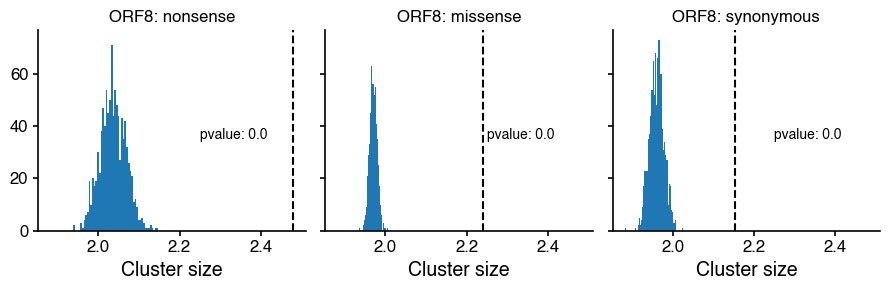

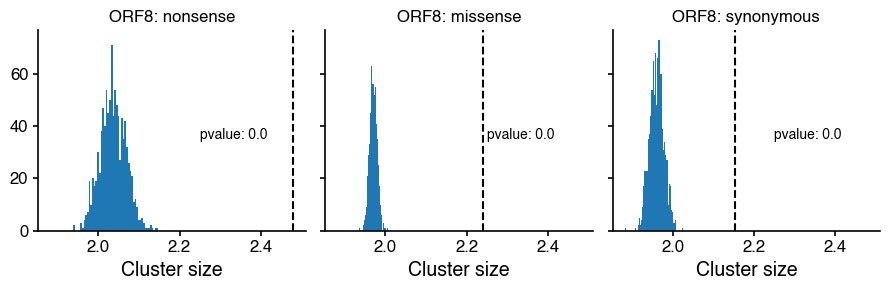

In [7]:
plot_permutation(orf8_1000,'ORF8','Cluster size','leaf_count',2.25,35)

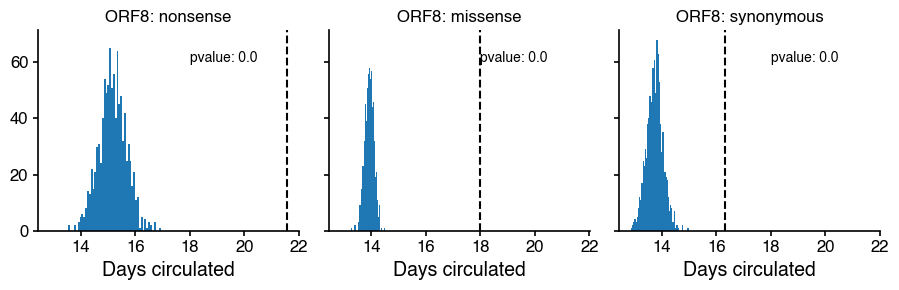

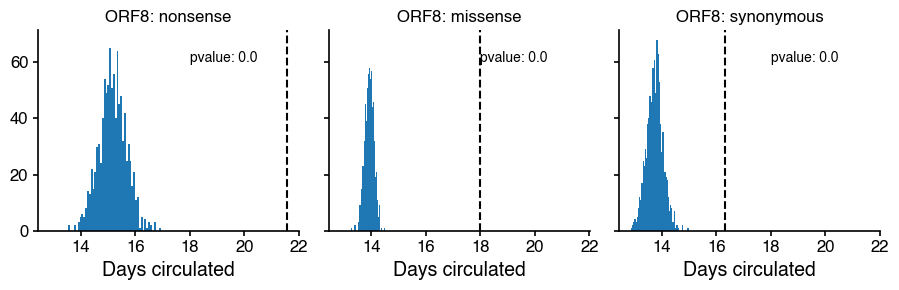

In [11]:
plot_permutation(orf8_1000,'ORF8','Days circulated','days_circulated',18,60)